In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import GaussianLikelihood
from torch.utils.data import DataLoader, TensorDataset


import matplotlib.pyplot as plt
import seaborn as sns
from figurefirst import mpl_functions
from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc

import pandas as pd
import os
import numpy as np

from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
import linear_operator.settings as losettings
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor

from joblib import load, dump

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [8]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        base_kernel = gpytorch.kernels.RBFKernel()  # Default lengthscale
        base_kernel.lengthscale = 2.0
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# Load data
def load_data(file_path):
    df = pd.read_hdf(file_path)
    # scaler = StandardScaler()
    # X_scaled = scaler.fit_transform(df[['distance_along_streakline', 'nearest_from_streakline']])
    # X = torch.tensor(X_scaled, dtype=torch.float32).cuda()
    X = torch.tensor(df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).cuda()
    y = torch.tensor(df['odor'].values, dtype=torch.float32).cuda()    
    return X, y
    

def train_gp_for_file(file_path):
    X, y = load_data(file_path)
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    # likelihood.initialize(noise=1e-3) 
    likelihood.noise_covar.initialize(noise=0.009)
    # likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    # model = GPModel(X, y, likelihood).cuda()

    model = GPModel(X, y, likelihood).cuda()
    model.covar_module.base_kernel.initialize(lengthscale=1.0)
    model.covar_module.initialize(outputscale=1.0)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()
    
    for i in range(100):  # Fixed number of iterations
        optimizer.zero_grad()
        output = model(X)
        loss = -mll(output, y)
        loss.backward()
        optimizer.step()
        
    return model



def load_and_concatenate_data(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    df_list = [pd.read_hdf(file_path) for file_path in all_files]
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

def train_gp_on_combined_data(combined_df, batch_size):
    likelihood = gpytorch.likelihoods.GaussianLikelihood().cuda()
    likelihood.initialize(noise=1e-4)

    model = None

    for i in range(0, len(combined_df), batch_size):
        batch_df = combined_df.iloc[i:i+batch_size]
        X_batch = torch.tensor(batch_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).cuda()
        y_batch = torch.tensor(batch_df['odor'].values, dtype=torch.float32).cuda()
        
        if model is None:
            # Initialize model
            model = GPModel(X_batch, y_batch, likelihood).cuda()
            model.covar_module.base_kernel.initialize(lengthscale=1.0)
            model.covar_module.initialize(outputscale=1.0)
        else:
            # Update model with new batch
            model.set_train_data(inputs=X_batch, targets=y_batch, strict=False)
        
        optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        model.train()
        likelihood.train()
        with losettings.max_cg_iterations(2000):
            for _ in range(100):  # Fewer iterations may be needed for each batch
                optimizer.zero_grad()
                output = model(X_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                optimizer.step()
    
    return model

folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

trained_models = {}
for file_path in all_files:
    gp_model = train_gp_for_file(file_path)
    trained_models[file_path] = gp_model
    print(f"Completed training for file: {file_path}")
print("Done")


# # Use the functions

# folder_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/"
# combined_df = load_and_concatenate_data(folder_path)
# batch_size = 6000 # Adjust the batch size based on your system's memory capacity
# gp_combined_model = train_gp_on_combined_data(combined_df, batch_size)


Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag15.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag5.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag20.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag9.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag6.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag13.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag8.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag12.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag17.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag16.h5
Completed training for file: /home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/di

In [2]:

# Define a standard Gaussian Process Model
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Function to load and concatenate data
def load_and_concatenate_data(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    df_list = [pd.read_hdf(file_path) for file_path in all_files]
    return pd.concat(df_list, ignore_index=True)

# Function to train GP models on mini-batches
def train_gp_on_mini_batches(combined_df, learning_rate=0.05, training_iterations=50, batch_size=1500):
    # Convert dataset to tensor and create a DataLoader for mini-batches
    X_all = torch.tensor(combined_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32)
    y_all = torch.tensor(combined_df['odor'].values, dtype=torch.float32)
    dataset = TensorDataset(X_all, y_all)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    batch_models = []
    batch_predictions = []
    batch_uncertainties = []

    for iteration in range(training_iterations):
        total_loss = 0
        for i, (X_batch, y_batch) in enumerate(dataloader):
            # Move batch data to the same device as the model
            X_batch = X_batch.cuda()
            y_batch = y_batch.cuda()

            # Initialize model and likelihood for each batch
            likelihood = GaussianLikelihood().cuda()
            likelihood.noise_covar.initialize(noise=1e-4)  # Adjust this value based on your noise level
            model = GPModel(X_batch, y_batch, likelihood).cuda()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            optimizer.zero_grad()
            output = model(X_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            with torch.no_grad():
                batch_pred = model(X_batch).mean.cpu().numpy()
                batch_uncertainty = model(X_batch).variance.sqrt().cpu().numpy()
                batch_predictions.append(batch_pred)
                batch_uncertainties.append(batch_uncertainty)

            batch_models.append(model)

            if (i + 1) % 50 == 0:
                print(f"Iteration {iteration+1}/{training_iterations}, Batch {i+1}, Current Loss: {loss.item()}")

        avg_loss = total_loss / len(dataloader)
        print(f"End of Iteration {iteration+1}, Average Loss: {avg_loss}")

    return batch_models, batch_predictions, batch_uncertainties



# Load data and train the models on mini-batches
# folder_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/"
folder_path = "/home/beast/An/data/Sept13Plumes/plume1/train/"
combined_df = load_and_concatenate_data(folder_path)
batch_models, batch_predictions, batch_uncertainties = train_gp_on_mini_batches(combined_df, learning_rate=0.05, 
                                                                                training_iterations=50, batch_size=1000)


End of Iteration 1, Average Loss: 109.81201040744781
End of Iteration 2, Average Loss: 128.93378567695618
End of Iteration 3, Average Loss: 83.35928678512573
End of Iteration 4, Average Loss: 140.98853039741516
End of Iteration 5, Average Loss: 79.99924504756927
End of Iteration 6, Average Loss: 90.53892350196838
End of Iteration 7, Average Loss: 106.0691859126091
End of Iteration 8, Average Loss: 135.87142872810364
End of Iteration 9, Average Loss: 119.87582588195801
End of Iteration 10, Average Loss: 176.96816325187683
End of Iteration 11, Average Loss: 142.57059705257416
End of Iteration 12, Average Loss: 170.846453666687
End of Iteration 13, Average Loss: 143.11775588989258
End of Iteration 14, Average Loss: 143.63251531124115
End of Iteration 15, Average Loss: 131.88547033071518
End of Iteration 16, Average Loss: 140.1707456111908
End of Iteration 17, Average Loss: 104.96795380115509
End of Iteration 18, Average Loss: 162.9184786081314
End of Iteration 19, Average Loss: 169.808464

In [3]:
def predict_with_batch_models(batch_models, X_test):
    batch_model_predictions = []

    for model in batch_models:
        model.eval()
        with torch.no_grad():
            preds = model(X_test).mean.cpu().numpy()
            batch_model_predictions.append(preds)

    return np.array(batch_model_predictions) 

def compute_batch_uncertainties(batch_models, X_test):
    batch_model_uncertainties = []

    for model in batch_models:
        model.eval()
        with torch.no_grad():
            variances = model(X_test).variance.sqrt().cpu().numpy()
            batch_model_uncertainties.append(variances)

    return np.array(batch_model_uncertainties) 

test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)
y_true = test_df['odor'].values

X_test_tensor = torch.tensor(test_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).cuda()

all_batch_predictions = predict_with_batch_models(batch_models, X_test_tensor)  
all_batch_uncertainties = compute_batch_uncertainties(batch_models, X_test_tensor)

def aggregate_time_point_predictions(all_batch_predictions, all_batch_uncertainties):
    # Weighted average aggregation for each time point
    weights = 1.0 / np.square(all_batch_uncertainties)  # Inverse-variance weighting
    weighted_preds = all_batch_predictions * weights
    aggregated_predictions = np.sum(weighted_preds, axis=0) / np.sum(weights, axis=0)

    return aggregated_predictions

# Aggregate predictions for each time point in test data
aggregated_time_point_predictions = aggregate_time_point_predictions(all_batch_predictions, all_batch_uncertainties)

# Calculate regression metrics
mse = mean_squared_error(y_true, aggregated_time_point_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, aggregated_time_point_predictions)
r2 = r2_score(y_true, aggregated_time_point_predictions)

# Print Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


/home/beast/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


Mean Squared Error: 0.21106849611760056
Root Mean Squared Error: 0.45942191514728653
Mean Absolute Error: 0.1576107403792891
R-squared: 0.7307866758743664


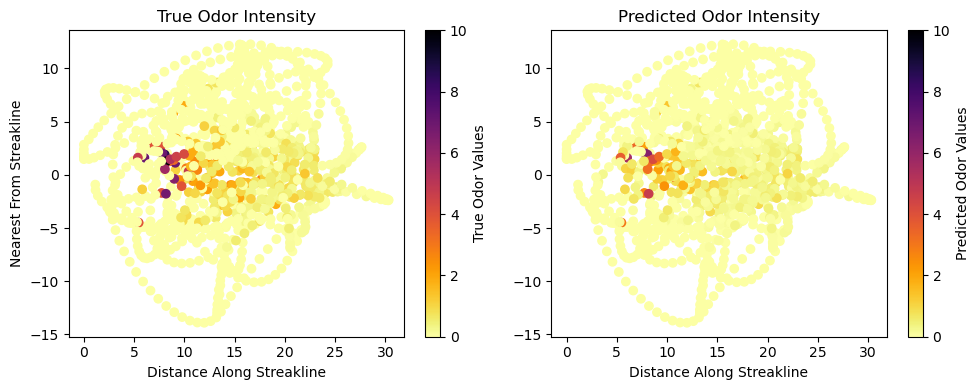

In [4]:
f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0,vmax=10)  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=aggregated_time_point_predictions, cmap='inferno_r',vmin=0,vmax=10)  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

### Performance of Train Data

Mean Squared Error: 0.7254431117165443
Root Mean Squared Error: 0.8517294827094717
Mean Absolute Error: 0.3191618404524626
R-squared: 0.07471292418533182


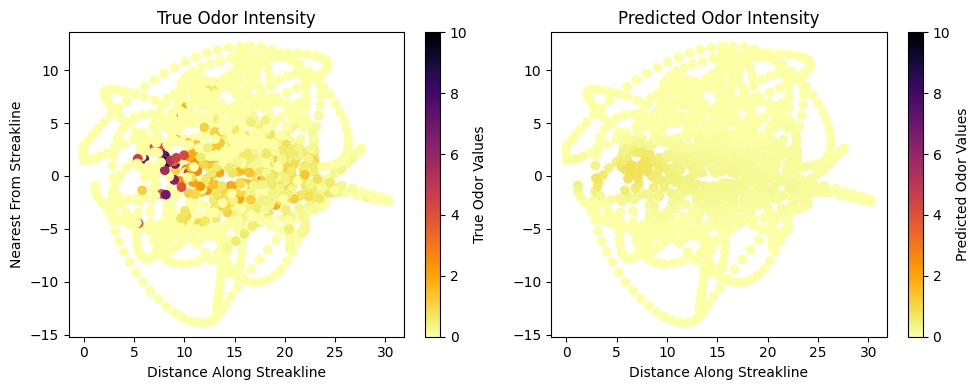

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
test_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)


X_test_tensor = torch.tensor(test_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).to(device)
y_true = test_df['odor'].values

## Combined Model

gp_combined_model.eval()
# GP in eval mode
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_combined_model(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()

# Calculate regression metrics
mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0,vmax=10)  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_mean, cmap='inferno_r',vmin=0,vmax=10)  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

/home/vbl/pywork38/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


Mean Squared Error: 0.0027151194350198437
Root Mean Squared Error: 0.05210680795270272
Mean Absolute Error: 0.02083051408174814
R-squared: 0.9965369235961555


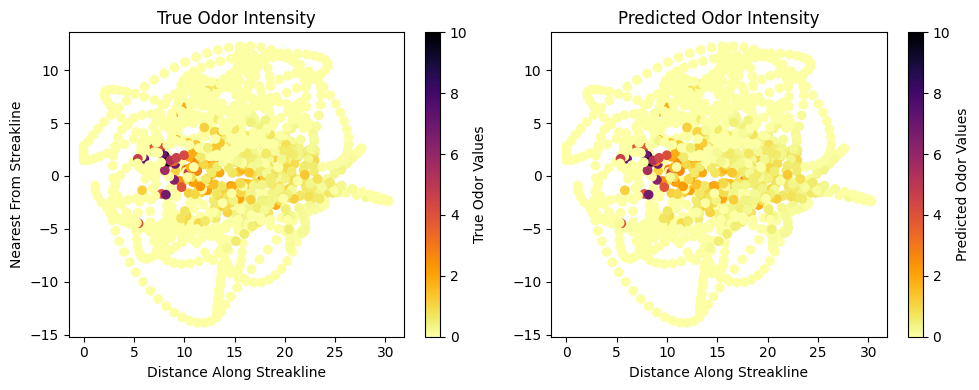

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Testing phase
# test_file_path = "/home/beast/An/data/Sept13Plumes/plume1/train/diag17.h5"
test_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag17.h5"
test_df = pd.read_hdf(test_file_path)

gp = trained_models[test_file_path]

X_test_tensor = torch.tensor(test_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).cuda()
y_true = test_df['odor'].values

# GP in eval mode
gp.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()
    y_pred_std = observed_pred.stddev.cpu().numpy()


mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

# Printing the Metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


f, axes = plt.subplots(1, 2, figsize=(10, 4))

# True Odor Values (Continuous)
sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=test_df['odor'], cmap='inferno_r', vmin=0,vmax=10)  # Use actual odor values
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted Odor Values (Continuous)
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], 
                      c=y_pred_mean, cmap='inferno_r',vmin=0,vmax=10)  # Use continuous predicted values
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

f.tight_layout()

### Performance on Test Data

Mean Squared Error: 0.586846348946052
Root Mean Squared Error: 0.7660589722378115
Mean Absolute Error: 0.36762034859514914
R-squared: -2.136544298721881


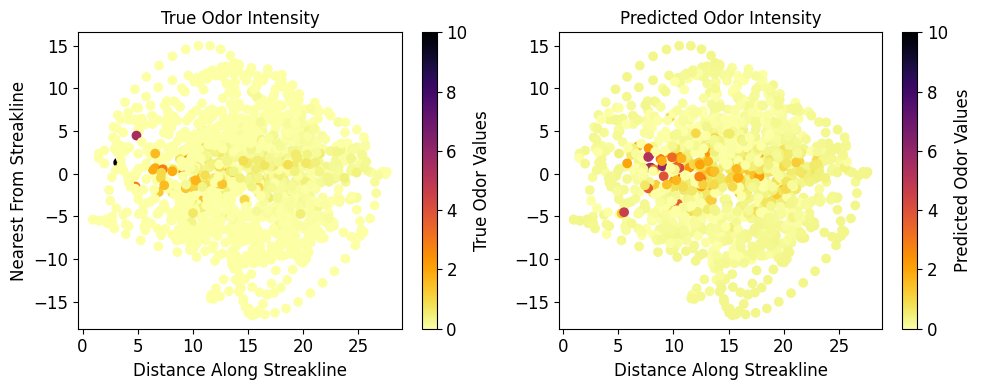

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

representative_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train/diag17.h5"
gp_representative = trained_models[representative_file_path].to(device)

test_file_path = "/home/vbl/whileAtHome/data/Sept13Plumes/plume1/diag1.h5"
test_df = pd.read_hdf(test_file_path)

# Ensure 'odor' column is used for continuous predictions
X_test_tensor = torch.tensor(test_df[['distance_along_streakline', 'nearest_from_streakline']].values, dtype=torch.float32).to(device)
y_true = test_df['odor'].values  # Use continuous odor values

# Predict using the GP model
gp_representative.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = gp_representative(X_test_tensor)
    y_pred_mean = observed_pred.mean.cpu().numpy()

mse = mean_squared_error(y_true, y_pred_mean)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred_mean)
r2 = r2_score(y_true, y_pred_mean)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")


f, axes = plt.subplots(1, 2, figsize=(10, 4))

sc1 = axes[0].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=y_true, 
                      cmap='inferno_r',vmin=0,vmax=10)
cbar1 = plt.colorbar(sc1, ax=axes[0])
cbar1.set_label('True Odor Values')
axes[0].set_title('True Odor Intensity')
axes[0].set_xlabel('Distance Along Streakline')
axes[0].set_ylabel('Nearest From Streakline')

# Predicted continuous odor values
sc2 = axes[1].scatter(test_df['distance_along_streakline'], test_df['nearest_from_streakline'], c=(y_pred_mean), 
                      cmap='inferno_r',vmin=0,vmax=10)
cbar2 = plt.colorbar(sc2, ax=axes[1])
cbar2.set_label('Predicted Odor Values')
axes[1].set_title('Predicted Odor Intensity')
axes[1].set_xlabel('Distance Along Streakline')

mpl_functions.set_fontsize(f, 12)
f.tight_layout()


In [132]:
x=pd.read_hdf('/home/vbl/whileAtHome/data/Sept13Plumes/plume1/train_raw/diag1.h5')

def calculate_distance_from_source(df):
    source = np.array([[0,0]])
    odor_position = np.array([[df.x[i],df.y[i]] for i in range (len(df))]) 

    distance_from_source = np.array([cdist(odor_position,source)]).flatten()
    df['distance_from_source'] = distance_from_source
    
    
calculate_distance_from_source(x)
osc.get_time_col(test_df,0.3)

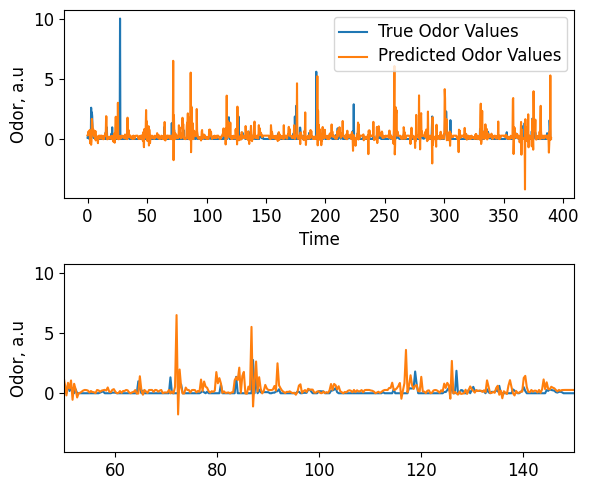

In [133]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 5))

ax1.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax1.plot(test_df.time, y_pred_mean, label= 'Predicted Odor Values')
ax1.set_ylabel('Odor, a.u')
ax1.set_xlabel('Time')
ax1.legend()
mpl_functions.set_fontsize(ax1, 14)

ax2.plot(test_df.time, test_df.odor, label ='True Odor Values')
ax2.plot(test_df.time, y_pred_mean, label= 'Predicted Odor Values')
ax2.set_ylabel('Odor, a.u')
# ax2.set_xlabel('Time')
# ax2.legend()
ax2.set_xlim([50, 150])
mpl_functions.set_fontsize(ax2, 12)
f.tight_layout()

In [134]:
store = np.array(x.distance_from_source.iloc[100:])
test_df['distance_from_source']=store
test_df['predicted_odor']=y_pred_mean


def cal_stat(df,index, index_predicted,fdf, fdf_predicted):
    osc.avg_distance(df,index,fdf)
    osc.mean_conc(df,index,fdf)
    osc.whiff_blank_duration(df,index,fdf)
    osc.std_whiff(df,index,fdf)
    osc.mean_avg(df,index,fdf)
    osc.encounter_frequency(df,index,fdf,1,2)
    osc.mean_t(df,index,fdf)
    
    osc.avg_distance(df,index_predicted,fdf_predicted)
    osc.predicted_mean_conc(df,index_predicted,fdf_predicted)
    osc.whiff_blank_duration(df,index_predicted,fdf_predicted)
    osc.std_whiff_predicted(df,index_predicted,fdf_predicted)
    osc.mean_avg_predicted(df,index_predicted,fdf_predicted)
    osc.encounter_frequency_predicted(df,index_predicted,fdf_predicted,1,2)
    osc.mean_t(df,index_predicted,fdf_predicted)
        
np.seterr(divide='ignore')
index = osc.get_index(test_df.odor,0.5)
index_predicted = osc.get_index(test_df.predicted_odor,0.5)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(test_df,index,index_predicted,fdf, fdf_predicted)

fdf.keys()

/home/vbl/whileAtHome/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1
/home/vbl/whileAtHome/plume_sim/odor_stat_calculations.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

In [90]:
fdf_predicted.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

#### Individual Whiff Statistics

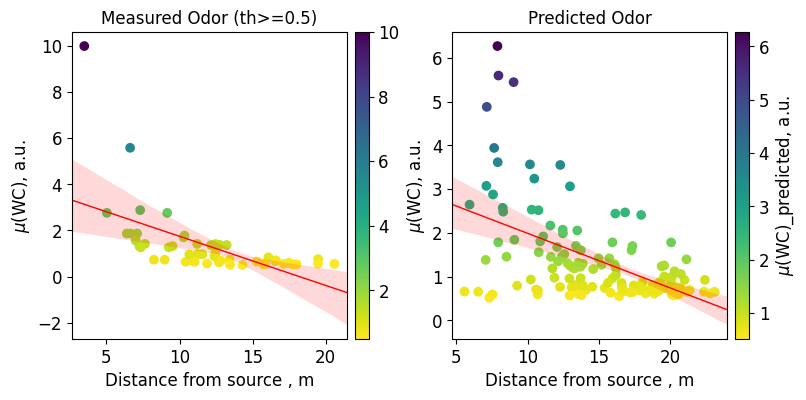

In [91]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Measured Odor (th>=0.5)')

u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Duration

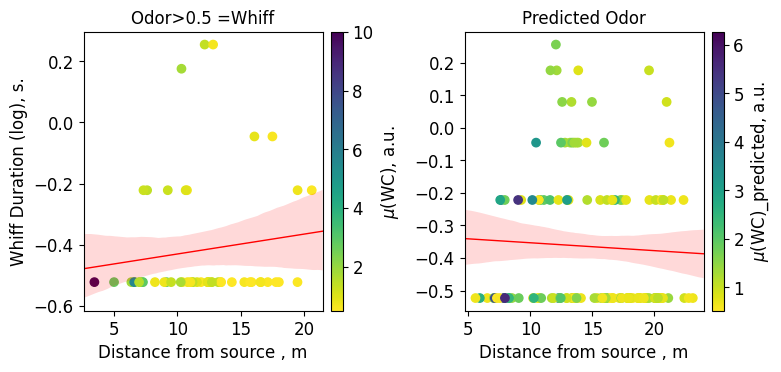

In [92]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Frequency

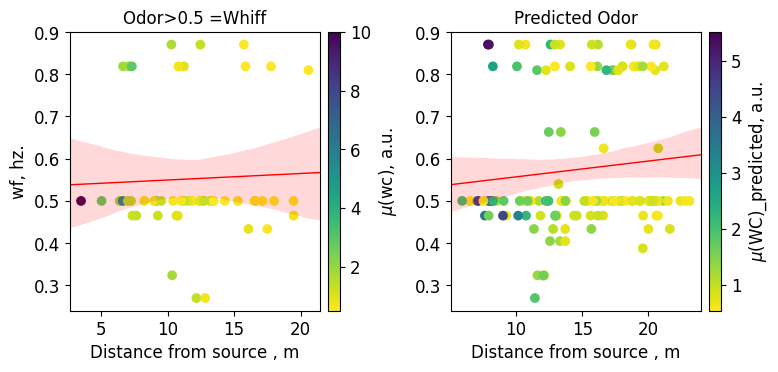

In [135]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.wf, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.wf , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wf, hz.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.wf, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.wf , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Standard Deviation

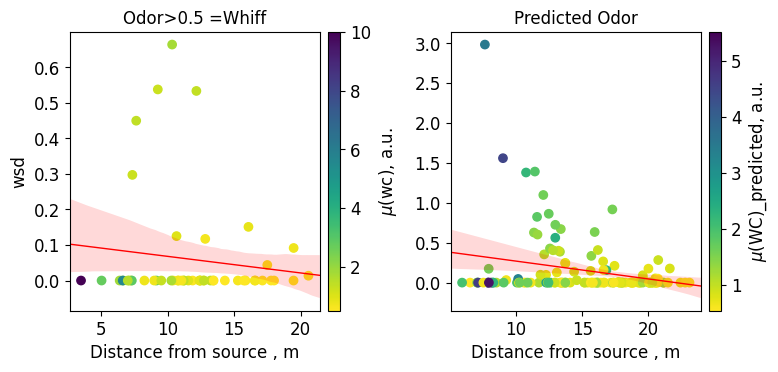

In [138]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.std_whiff, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.std_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wsd')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.std_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.std_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

#### Whiff Moving Average

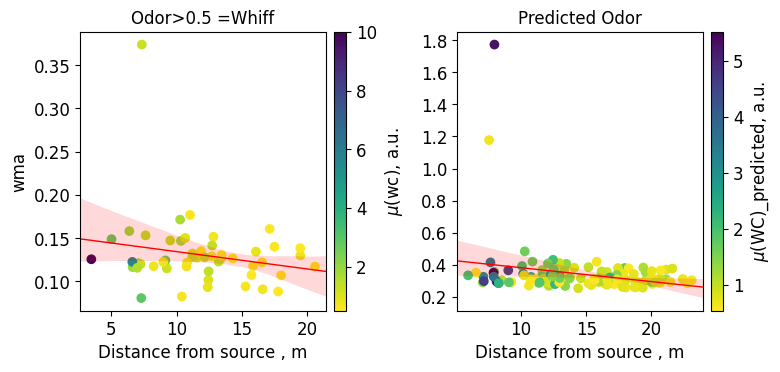

In [139]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.whiff_ma, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.whiff_ma , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('wma')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.whiff_ma, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.whiff_ma , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

### Calculating Meta Whiff Stats

In [140]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)
fdf_predicted_new = create_class_column(fdf_predicted)



In [141]:
lookback_time = 3

trainset= fdf_new
# trainset= fdf_predicted_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train,Nrows_train,mean_time_train = osc.gather_stat_timed(trainset,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)



/tmp/ipykernel_5289/2409865337.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/2409865337.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/2409865337.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/2409865337.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when 

In [142]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.577
Method:                 Least Squares   F-statistic:                     435.3
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          3.44e-236
Time:                        03:55:03   Log-Likelihood:                -3462.5
No. Observations:                1274   AIC:                             6935.
Df Residuals:                    1269   BIC:                             6961.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     24.4741      0.359     68.172      0.0

In [143]:
lookback_time = 3

trainset_predicted= fdf_predicted_new
# trainset= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,mean_time_train_predicted = osc.gather_stat_timed(trainset_predicted,distance_class,
                      lookback_time, Xtrain,ytrain,D_train,Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)
traindf_predicted['nwhiffs'] = np.delete(Nrows_train_predicted, c1)



/tmp/ipykernel_5289/3881888269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/3881888269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/3881888269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_5289/3881888269.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when 

In [144]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     358.9
Date:                Fri, 05 Jan 2024   Prob (F-statistic):          1.15e-239
Time:                        03:55:12   Log-Likelihood:                -6563.9
No. Observations:                2275   AIC:                         1.314e+04
Df Residuals:                    2270   BIC:                         1.317e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.7257      0.192    102.603      0.0

### Whiff Concentration

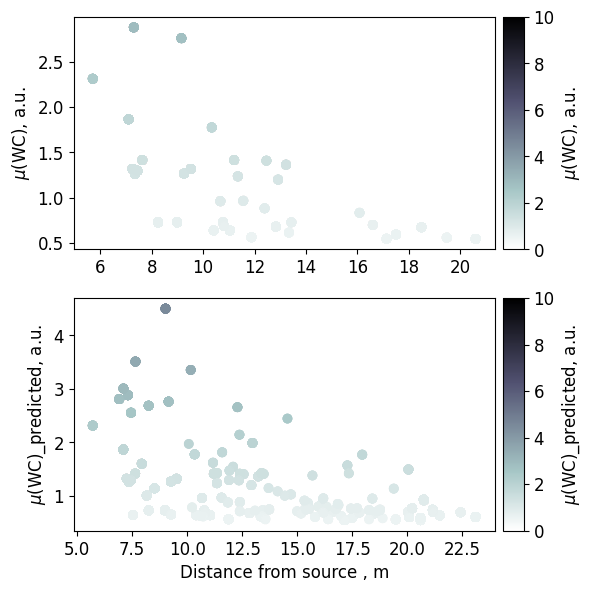

In [145]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WC), a.u.')
ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


### Whiff Frequency

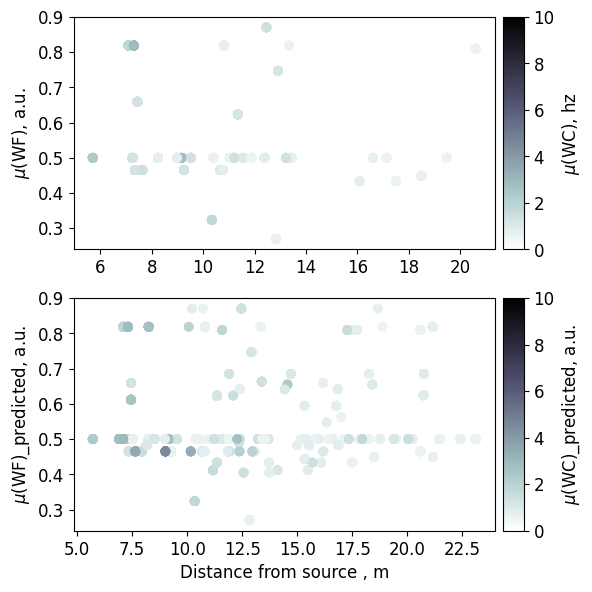

In [150]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WF), a.u.')
ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


### Whiff Duration

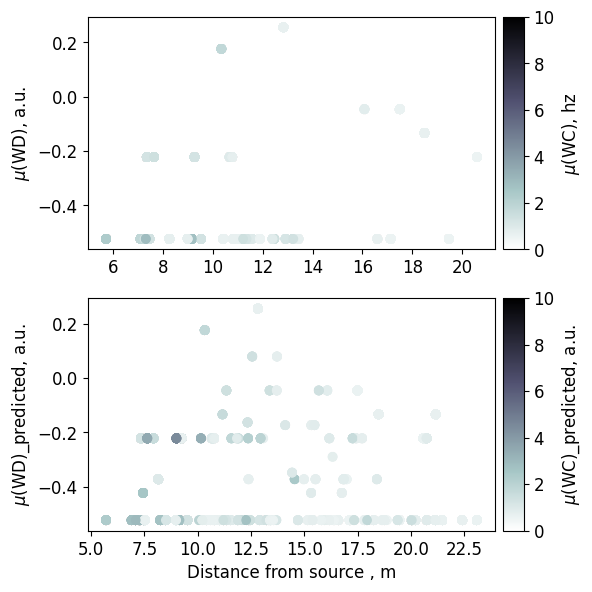

In [151]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WD), a.u.')
ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


### Whiff Moving Average

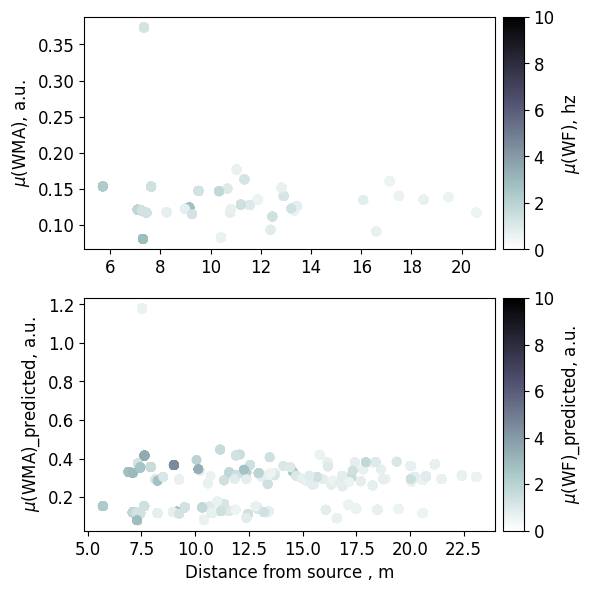

In [152]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WMA), a.u.')
ax[1].set_ylabel('$\mu$(WMA)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


#### Whiff Standard Deviation

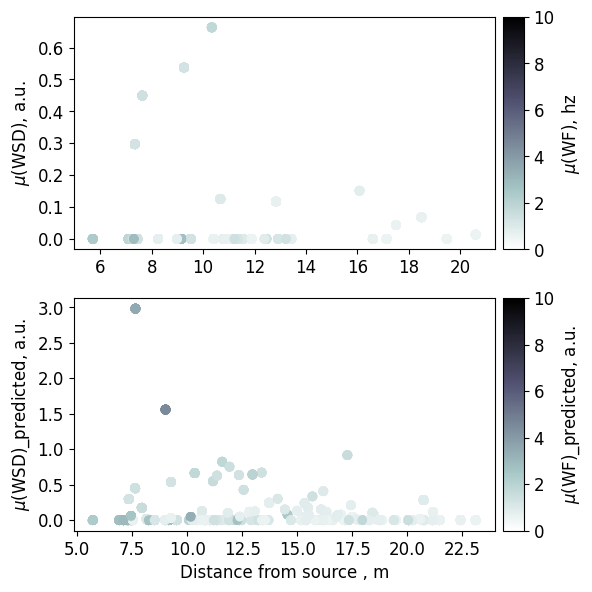

In [154]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF), hz')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WF)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WSD), a.u.')
ax[1].set_ylabel('$\mu$(WSD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
